# Empirical Marginal Distribution of CLIP Model

This notebook recreates Figure 3 of the manuscript, which shows the empirical marginals $P_{\theta, X}^{(k)}$, $Q_{\theta, X}^{(k)}$, $P_{\theta, Y}^{(k)}$, and $Q_{\theta, Y}^{(k)}$ as described in Sections 2 and 4 of the paper. This marginal is computed via the following steps:
1. Randomly initialize a CLIP model $(f_{\theta_I}, f_{\theta_T})$ (as in the notation of Section 2 Example 2).
2. Pass a minibatch of images-text pairs $\{(X_1, Y_1), \ldots (X_n, Y_n)\}$ through the model.
3. Compute $P_{\theta}^{(k)}$ and $Q_{\theta}^{(k)}$ using Equation 5, which are joint probability mass functions (i.e.~$n \times n$ matrices).
4. Marginalize the joint probability mass functions to compute  $P_{\theta, X}^{(k)}$, $Q_{\theta, X}^{(k)}$, $P_{\theta, Y}^{(k)}$, and $Q_{\theta, Y}^{(k)}$.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..")
from src.multimodal_models import MiniCLIP
from src.multimodal_data import get_multimodal_dataloaders

import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams['legend.fontsize'] = 33
mpl.rcParams['axes.titlesize'] = 32
# mpl.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

Select the device below.

In [2]:
DEVICE = "cuda:0"

## Load Data and Model

We use a subset of image/text embeddings that are included in `data`. To recreate all embeddings, see `notebooks/create_imagenet_captions.ipynb`. Recall that examples are subsets of the [ImageNet-Captions dataset](https://github.com/mlfoundations/imagenet-captions?tab=readme-ov-file) that have been embedded by a CLIP ViT-B/32 model.

![imagenet](imagenet.png)

In [7]:
# load model
model_cfg = {
    "architecture": "miniclip",
    "in_features_img": 512,
    "hidden_size_img": 256,
    "n_layers_img": 2,
    "in_features_txt": 512,
    "hidden_size_txt": 256,
    "n_layers_txt": 2,
    "out_features": 128,
    "loss": "clip",
}

model = MiniCLIP(**model_cfg).to(DEVICE)

In [14]:
# load data
X, Y = torch.load("../data/clip_image_embeds.pt"), torch.load("../data/clip_text_embeds.pt")

print(X.shape)
print(Y.shape)

with torch.no_grad():
    loss, logits = model(X.to(DEVICE), Y.to(DEVICE))

print(logits.shape)

torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 16])


## Define Losses

The `logits` variable above stores an $n \times n$ matrix which is normalized to create a probability measure. Next, we show the functions used for computing $P_{\theta}^{(k)}$ and $Q_{\theta}^{(k)}$.

In [15]:
def get_marginals(log_prob1, log_prob2):
    prob1 = torch.exp(log_prob1).cpu()
    prob2 = torch.exp(log_prob2).cpu()
    return prob1.sum(dim=0) / prob1.sum(), prob1.sum(dim=1) / prob1.sum(), prob2.sum(dim=0) / prob2.sum(), prob2.sum(dim=1) / prob2.sum()

def jointly_centered_loss(logits):
    norm_factor = torch.logsumexp(torch.flatten(logits), dim=0)
    log_prob = logits - norm_factor
    return log_prob, log_prob

def clip_loss(logits):
    cx   = F.log_softmax(logits, dim=1)
    cy   = F.log_softmax(logits, dim=0)
    return cx, cy

def doubly_centered_loss(logits):
    cx   = F.log_softmax(logits, dim=1)
    cy   = F.log_softmax(logits, dim=0)
    cycx = F.log_softmax(cx, dim=0)
    cxcy = F.log_softmax(cy, dim=1)
    return cycx, cxcy

## Create Figure

We now put it all together to create the final figure. Each panel is created with a different loss function.

In [16]:
def create_figure(m1x, m1y, m2x, m2y, k):
    sns.set_style("white")
    color = "dodgerblue"
    color2 = "lightsalmon"

    fig, axes = plt.subplots(2, 2, figsize=(8, 7), sharex=True, sharey="row")
    ticks = torch.arange(len(m1x))
    width = 1.0

    axes[0, 0].bar(ticks, m1x, color=color2, width=width)
    axes[0, 1].bar(ticks, m1y, color=color, width=width)
    axes[1, 0].bar(ticks, m2x, color=color, width=width)
    axes[1, 1].bar(ticks, m2y, color=color2, width=width)

    ms = [m1x, m1y, m2x, m2y]
    for i, ax in enumerate([axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]):
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_ylim(0.0, 5 * torch.mean(ms[i]))

    labelpad = -24.0
    coords = (0.05, 0.85)
    fontsize = 18
    match k:
        case 0:
            axes[0, 0].text(*coords, r"$P^{(0)}_{\theta, X}(x)$", transform=axes[0, 0].transAxes, fontsize=fontsize)
            axes[0, 1].text(*coords, r"$P^{(0)}_{\theta, Y}(y)$", transform=axes[0, 1].transAxes, fontsize=fontsize)
            axes[1, 0].text(*coords, r"$Q^{(0)}_{\theta, X}(x)$", transform=axes[1, 0].transAxes, fontsize=fontsize)
            axes[1, 1].text(*coords, r"$Q^{(0)}_{\theta, Y}(y)$", transform=axes[1, 1].transAxes, fontsize=fontsize)
        case 1:
            axes[0, 0].text(*coords, r"$P^{(1)}_{\theta, X}(x)$", transform=axes[0, 0].transAxes, fontsize=fontsize)
            axes[0, 1].text(*coords, r"$P^{(1)}_{\theta, Y}(y)$", transform=axes[0, 1].transAxes, fontsize=fontsize)
            axes[1, 0].text(*coords, r"$Q^{(1)}_{\theta, X}(x)$", transform=axes[1, 0].transAxes, fontsize=fontsize)
            axes[1, 1].text(*coords, r"$Q^{(1)}_{\theta, Y}(y)$", transform=axes[1, 1].transAxes, fontsize=fontsize)
        case 2:
            axes[0, 0].text(*coords, r"$P^{(2)}_{\theta, X}(x)$", transform=axes[0, 0].transAxes, fontsize=fontsize)
            axes[0, 1].text(*coords, r"$P^{(2)}_{\theta, Y}(y)$", transform=axes[0, 1].transAxes, fontsize=fontsize)
            axes[1, 0].text(*coords, r"$Q^{(2)}_{\theta, X}(x)$", transform=axes[1, 0].transAxes, fontsize=fontsize)
            axes[1, 1].text(*coords, r"$Q^{(2)}_{\theta, Y}(y)$", transform=axes[1, 1].transAxes, fontsize=fontsize)

    axes[1, 0].set_xlabel(r"$x$")
    axes[1, 1].set_xlabel(r"$y$")

    fig.tight_layout(pad=2.0)

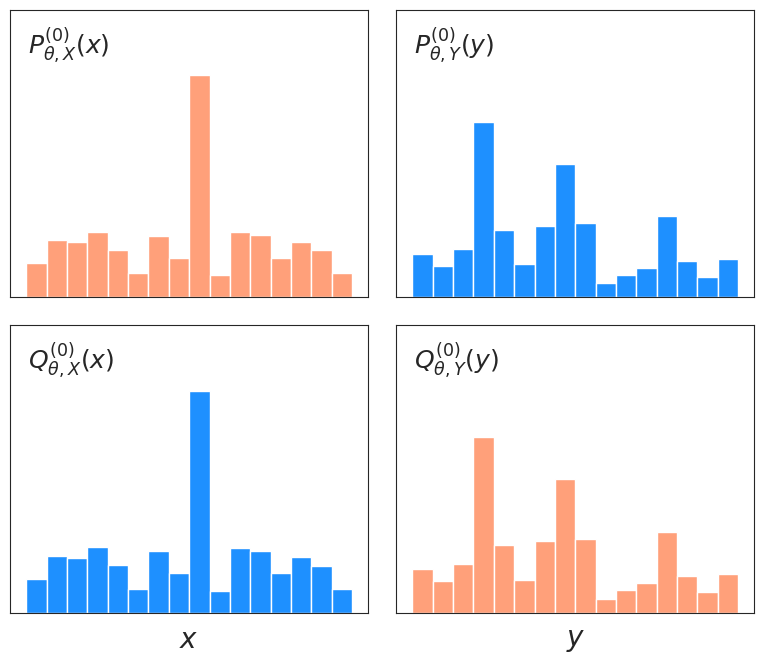

In [17]:
m1x, m1y, m2x, m2y = get_marginals(*jointly_centered_loss(logits))
create_figure(m1x, m1y, m2x, m2y, 0)

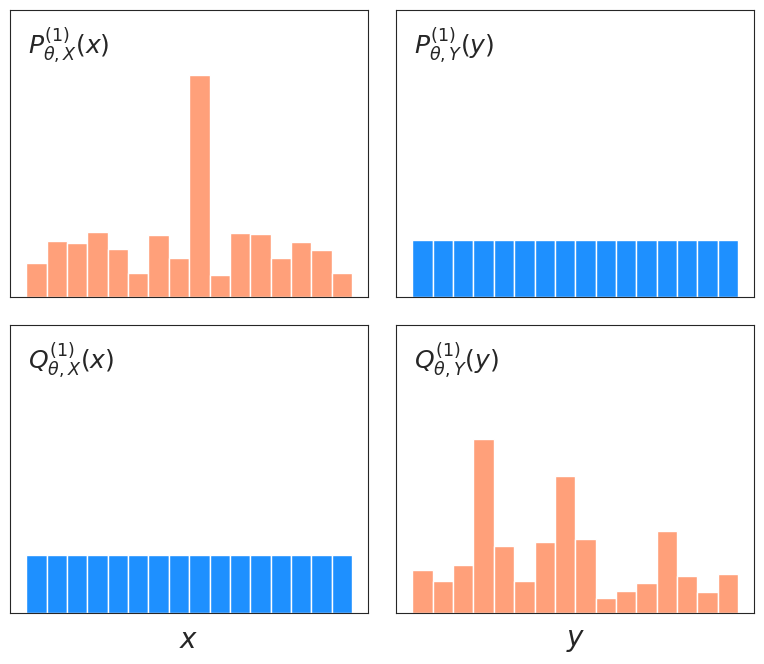

In [18]:
m1x, m1y, m2x, m2y = get_marginals(*clip_loss(logits))
create_figure(m1x, m1y, m2x, m2y, 1)

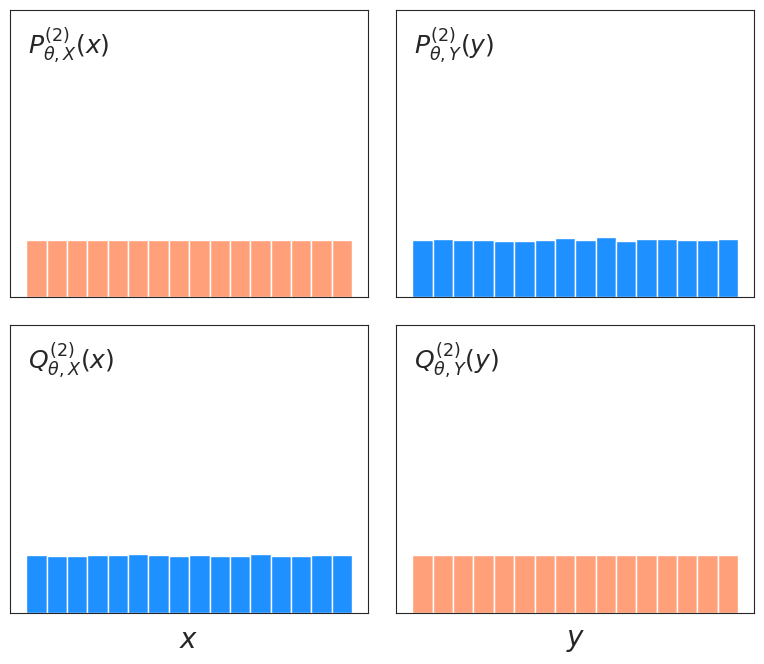

In [19]:
m1x, m1y, m2x, m2y = get_marginals(*doubly_centered_loss(logits))
create_figure(m1x, m1y, m2x, m2y, 2)